# Parity Problem

The parity problem yields an output of `1` if the input pattern contains an odd number of 1s and `0` otherwise. The XOR problem is the simplest parity problem in which the size of input patterns is two (Minsky and Papert, 1969).

Consider a feedforward neural network with a single hidden layer. Given the constraint that connections from  the input to the output units are not allowed, a minimum number of `N` hidden units is required to solve parity with input patterns of length `N` for a feedforward neural network with one hidden layer (Williams et al, 1985).

I will be using TensorFlow to model a feedforward neural network, NumPy to generate parity sequences, and Pyplot to visualize the training progress:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Define a feedforward neural network with a single hidden layer containing `N` units:

In [2]:
def parity_nn(input_length, num_units):
    # input placeholder
    x = tf.placeholder(
        dtype=tf.float32,
        shape=(None, input_length),
        name='x'
    )

    # network parameters
    w_1 = tf.Variable(
        name='w_1',
        initial_value=tf.truncated_normal(
            shape=(input_length, num_units),
            mean=0,
            stddev=1.0,
            dtype=tf.float32
        )
    )
    b_1 = tf.Variable(
        name='b_1',
        initial_value=tf.truncated_normal(
            shape=(num_units,),
            mean=0.01,
            stddev=0.1,
            dtype=tf.float32
        )
    )
    w_o = tf.Variable(
        name='w_o',
        initial_value=tf.truncated_normal(
            shape=(num_units, 1),
            mean=0,
            stddev=1.0,
            dtype=tf.float32
        )
    )
    b_o = tf.Variable(
        name='b_o',
        initial_value=tf.truncated_normal(
            shape=(1,),
            mean=0.01,
            stddev=0.1,
            dtype=tf.float32
        )
    )

    # define hidden layer
    net_w_1 = tf.add(tf.matmul(x, w_1), b_1)
    out_w_1 = tf.nn.tanh(net_w_1)
    # define output layer
    net_w_o = tf.add(tf.matmul(out_w_1, w_o), b_o)
    o = tf.nn.tanh(net_w_o)
    return x, o

The following function will generate input-output pairs of the parity problem:

In [3]:
def get_batch(input_length, batch_size):
    xs = [np.random.randint(0, 2, input_length) for _ in range(batch_size)]
    ys = [[0] if np.sum(x) % 2 == 0 else [1] for x in xs]
    return xs, ys

Let us start off by training a minimal neural network to approximate a parity problem of length `8`:


epoch: 9999
loss: 0.4974995255470276
x: [1 0 0 1 1 1 1 0]   d: [1]   o: [0.9887647]
x: [0 0 0 1 1 1 1 0]   d: [0]   o: [0.00592559]
x: [0 0 0 0 0 1 0 1]   d: [0]   o: [-0.01382716]
x: [0 1 1 1 0 1 0 1]   d: [1]   o: [0.9871797]
x: [0 0 0 0 1 1 0 1]   d: [1]   o: [0.98705435]

epoch: 19999
loss: 0.4325488805770874
x: [1 0 0 0 0 1 0 1]   d: [1]   o: [0.99328274]
x: [0 1 1 0 1 0 0 0]   d: [1]   o: [0.9952198]
x: [1 0 1 1 1 0 0 1]   d: [1]   o: [0.99482304]
x: [0 0 0 0 0 0 0 0]   d: [0]   o: [0.01102903]
x: [1 0 1 1 0 1 1 1]   d: [0]   o: [-0.07248541]

epoch: 29999
loss: 0.04572208970785141
x: [0 1 0 0 0 1 0 1]   d: [1]   o: [0.99592435]
x: [1 1 1 1 0 0 1 1]   d: [0]   o: [-0.02133236]
x: [1 1 1 1 1 0 0 1]   d: [0]   o: [-0.00457045]
x: [1 1 1 1 1 0 0 1]   d: [0]   o: [-0.00457045]
x: [0 0 1 1 0 0 0 0]   d: [0]   o: [0.01628708]

epoch: 39999
loss: 0.02304884046316147
x: [1 0 1 0 0 1 1 1]   d: [1]   o: [0.94022715]
x: [0 0 1 0 1 1 1 1]   d: [1]   o: [0.9974899]
x: [0 0 1 0 1 1 0 0]   d: 

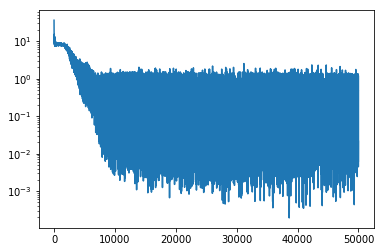

In [4]:
def main():
    # parity problem difficulty
    input_length = 8

    # hyper-parameters
    num_units = 8
    num_epochs = 50000
    learning_rate = 0.01
    batch_size = 64
    show_every = num_epochs / 5

    # build network
    x, o = parity_nn(
        input_length=input_length,
        num_units=num_units
    )

    # define cost function
    d = tf.placeholder(
        name='d',
        dtype=tf.float32,
        shape=(None, 1)
    )
    l2_loss = tf.nn.l2_loss(d - o)

    # define optimization process
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_step = optimizer.minimize(loss=l2_loss)

    # cumulative loss
    l2_losses = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # deltas are applied after cumulative evaluation of batch at each epoch
        for epoch in range(num_epochs):
            in_ex, out_ex = get_batch(input_length, batch_size)

            # run a train step
            _, l2_loss_val = sess.run(
                fetches=(train_step, l2_loss),
                feed_dict={
                    x: in_ex,
                    d: out_ex
                }
            )
            l2_losses.append(l2_loss_val)

            # evaluate network performance
            if ((epoch + 1) % show_every == 0) or ((epoch + 1) == num_epochs):
                print('\nepoch: {}'.format(epoch))
                print('loss: {}'.format(l2_loss_val))
                o_val = sess.run(
                    fetches=o,
                    feed_dict={x: in_ex}
                )
                for i, (x_, d_, o_) in enumerate(zip(in_ex, out_ex, o_val)):
                    if i < 5:
                        print('x: {}   d: {}   o: {}'.format(x_, d_, o_))

    plt.yscale('log')
    plt.plot(l2_losses)
    plt.draw()


if __name__ == '__main__':
    main()


This neural network was quick to converge. Let's remove one unit from the hidden layer to test if the bare minimum number of hidden units to solve the parity problem is indeed `N`:


epoch: 9999
loss: 0.505355715751648
x: [1 1 0 1 1 1 1 1]   d: [1]   o: [0.8662792]
x: [1 0 0 0 1 1 0 0]   d: [1]   o: [0.9822931]
x: [1 0 1 1 1 1 0 1]   d: [0]   o: [0.10296653]
x: [0 0 1 1 0 0 1 0]   d: [1]   o: [0.94615865]
x: [0 0 0 0 0 1 0 0]   d: [1]   o: [0.94032043]

epoch: 19999
loss: 0.5149173140525818
x: [0 1 1 0 0 0 0 0]   d: [0]   o: [0.01805729]
x: [1 0 0 1 1 0 0 0]   d: [1]   o: [0.9975529]
x: [1 1 1 0 1 0 1 0]   d: [1]   o: [0.99995226]
x: [0 1 0 0 1 0 0 0]   d: [0]   o: [0.00081921]
x: [0 0 1 1 0 0 1 1]   d: [0]   o: [0.00520463]

epoch: 29999
loss: 0.14466077089309692
x: [1 0 1 0 0 0 0 1]   d: [1]   o: [0.9689084]
x: [0 1 0 0 1 0 0 0]   d: [0]   o: [0.03598119]
x: [0 0 1 0 1 1 0 1]   d: [0]   o: [0.02754831]
x: [0 1 1 0 1 1 1 0]   d: [1]   o: [0.963034]
x: [1 0 0 1 1 1 1 0]   d: [1]   o: [0.9668563]

epoch: 39999
loss: 0.4527362287044525
x: [0 1 1 0 1 1 0 0]   d: [0]   o: [0.0329817]
x: [0 1 1 0 0 1 0 0]   d: [1]   o: [0.95847225]
x: [1 1 1 1 1 0 0 0]   d: [1]   o: [0

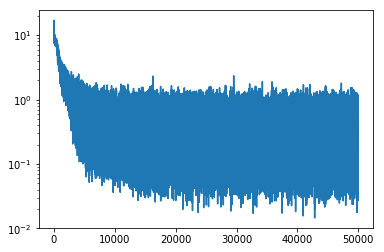

In [5]:
def main():
    # parity problem difficulty
    input_length = 8

    # hyper-parameters
    num_units = 7
    num_epochs = 50000
    learning_rate = 0.01
    batch_size = 64
    show_every = num_epochs / 5

    # build network
    x, o = parity_nn(
        input_length=input_length,
        num_units=num_units
    )

    # define cost function
    d = tf.placeholder(
        name='d',
        dtype=tf.float32,
        shape=(None, 1)
    )
    l2_loss = tf.nn.l2_loss(d - o)

    # define optimization process
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_step = optimizer.minimize(loss=l2_loss)

    # cumulative loss
    l2_losses = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # deltas are applied after cumulative evaluation of batch at each epoch
        for epoch in range(num_epochs):
            in_ex, out_ex = get_batch(input_length, batch_size)

            # run a train step
            _, l2_loss_val = sess.run(
                fetches=(train_step, l2_loss),
                feed_dict={
                    x: in_ex,
                    d: out_ex
                }
            )
            l2_losses.append(l2_loss_val)

            # evaluate network performance
            if ((epoch + 1) % show_every == 0) or ((epoch + 1) == num_epochs):
                print('\nepoch: {}'.format(epoch))
                print('loss: {}'.format(l2_loss_val))
                o_val = sess.run(
                    fetches=o,
                    feed_dict={x: in_ex}
                )
                for i, (x_, d_, o_) in enumerate(zip(in_ex, out_ex, o_val)):
                    if i < 5:
                        print('x: {}   d: {}   o: {}'.format(x_, d_, o_))

    plt.yscale('log')
    plt.plot(l2_losses)
    plt.draw()


if __name__ == '__main__':
    main()


The average error of the network with `N-1` hidden units was observed to be an order of magnitude greater than that with `N` hidden units.

### REFERENCES

Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1985). _Learning Internal Representations by Error Propagation_. Cambridge, MA: MIT Press.

Minsky, M. L., & Papert, S. (1969). _Perceptrons_. Cambridge, MA: MIT Press.